In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [5]:
# import torch

# # a = torch.ones((2,2))
# # b = torch.ones((2,2))*5
# # c = torch.ones((2,2))*8

# # d = torch.cat((a,b,c), dim=-1)

# # print(d)


# # ds = torch.split(d, 2, dim=-1)

# # print(ds[0].shape, ds[1].shape, ds[2].shape)

# # a = torch.randn(2000,3)
# a = torch.randn(2000,768)

# (b,c,d) = a.split(256, dim=-1)

print(b.shape)
# print(a[:,0].shape)
import torch.nn.functional as F
nocs = torch.zeros(10,10)

nocs[:,-1] = 1

probs = F.softmax(nocs, dim=1)
# get the predicted class IDs (i.e., the class with the highest probability)
_, predicted = torch.max(probs, dim=1)

print(predicted.shape)

torch.Size([2000, 256])
torch.Size([10])


In [6]:
print(predicted)

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9])


In [ ]:
import os, sys
sys.path.append("./src")
import torch
import torch.nn as nn
from data import get_split_dataset
import src.model.encoder as encoder
import util
from util.util import detach_all, numpy2tensor
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
from dotmap import DotMap

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

# Check world grid

In [1]:
side_length = 5
grid_size = 5

world_grid = util.get_world_grid([[-side_length, side_length],
                                  [0, side_length],
                                  [-side_length, side_length]], 
                                 [grid_size]).cuda()

print("Size of output grid: ", world_grid.shape)
world_grid = detach_all(world_grid)

NameError: name 'util' is not defined

In [8]:
world_grid = world_grid.reshape(1, grid_size, grid_size, grid_size, 3)

In [9]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(world_grid[0, ..., 0], world_grid[0, ..., 1], world_grid[0, ..., 2], alpha=0.2)
# ax.scatter(world_grid[0, 0, :, 0, 0], world_grid[0, 0, :, 0, 1], world_grid[0, 0, :, 0, 2], c="r")
# ax.scatter(world_grid[0, 0, :, 1, 0], world_grid[0, 0, :, 1, 1], world_grid[0, 0, :, 1, 2], c="g")
# ax.scatter(world_grid[0, 1, :, 0, 0], world_grid[0, 1, :, 0, 1], world_grid[0, 1, :, 0, 2], c="b")

ax.scatter(world_grid[0, 0, 0, 0, 0], world_grid[0, 0, 0, 0, 1], world_grid[0, 0, 0, 0, 2], c="r")
ax.scatter(world_grid[0, 0, 0, 1, 0], world_grid[0, 0, 0, 1, 1], world_grid[0, 0, 0, 1, 2], c="g")
ax.scatter(world_grid[0, 1, 0, 0, 0], world_grid[0, 1, 0, 0, 1], world_grid[0, 1, 0, 0, 2], c="b")


plt.xlabel("x")
plt.ylabel("y")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'y')

# Lets load some data

In [6]:
gpu_id = [0]
device = util.get_cuda(gpu_id[0])

In [7]:
dset = get_split_dataset("srn", "/data/graphics/toyota-pytorch/GQN_rooms/", want_split="val")

/data/graphics/toyota-pytorch/GQN_rooms/
/data/graphics/toyota-pytorch/GQN_rooms//val 
Loading SRN dataset /data/graphics/toyota-pytorch/GQN_rooms//val name: 


In [8]:
train_data_loader = torch.utils.data.DataLoader(
            dset,
            batch_size=1,
            shuffle=True,
            num_workers=1,
            pin_memory=False,
        )

for data in train_data_loader:
    break

In [9]:
# for data in train_data_loader:
#     break

In [10]:
# Code from calc_losses in train.py

all_images = data["images"].to(device=device)  # (SB, NV, 3, H, W)
all_images = (all_images *0.5) + 0.5 
SB, NV, _, H, W = all_images.shape
all_poses = data["poses"].to(device=device)  # (SB, NV, 4, 4)
all_bboxes = data.get("bbox")  # (SB, NV, 4)  cmin rmin cmax rmax
all_focals = data["focal"]  # (SB)
all_c = data.get("c")  # (SB)
z_near = 0.1
z_far = 7
ray_batch_size = 10000

all_bboxes = None
all_rgb_gt = []
all_rays = []
nviews = [5]

curr_nviews = nviews[torch.randint(0, len(nviews), ()).item()]
if curr_nviews == 1:
    image_ord = torch.randint(0, NV, (SB, 1))
else:
    image_ord = torch.empty((SB, curr_nviews), dtype=torch.long)
for obj_idx in range(SB):
    if all_bboxes is not None:
        bboxes = all_bboxes[obj_idx]
    images = all_images[obj_idx]  # (NV, 3, H, W)
    poses = all_poses[obj_idx]  # (NV, 4, 4)
    focal = all_focals[obj_idx]
    c = None
    if "c" in data:
        c = data["c"][obj_idx]
    if curr_nviews > 1:
        # Somewhat inefficient, don't know better way
        image_ord[obj_idx] = torch.from_numpy(
            np.random.choice(NV, curr_nviews, replace=False)
        )
    images_0to1 = images * 0.5 + 0.5

    cam_rays = util.gen_rays(
        poses, W, H, focal, z_near, z_far, c=c
    )  # (NV, H, W, 8)
    rgb_gt_all = images_0to1
    rgb_gt_all = (
        rgb_gt_all.permute(0, 2, 3, 1).contiguous().reshape(-1, 3)
    )  # (NV, H, W, 3)

    if all_bboxes is not None:
        pix = util.bbox_sample(bboxes, ray_batch_size)
        pix_inds = pix[..., 0] * H * W + pix[..., 1] * W + pix[..., 2]
    else:
        pix_inds = torch.randint(0, NV * H * W, (ray_batch_size,))

    rgb_gt = rgb_gt_all[pix_inds]  # (ray_batch_size, 3)
    rays = cam_rays.view(-1, cam_rays.shape[-1])[pix_inds].to(
        device=device
    )  # (ray_batch_size, 8)

    all_rgb_gt.append(rgb_gt)
    all_rays.append(rays)

all_rgb_gt = torch.stack(all_rgb_gt)  # (SB, ray_batch_size, 3)
all_rays = torch.stack(all_rays)  # (SB, ray_batch_size, 8)

image_ord = image_ord.to(device)
src_images = util.batched_index_select_nd(
    all_images, image_ord
)  # (SB, NS, 3, H, W)
src_poses = util.batched_index_select_nd(all_poses, image_ord)  # (SB, NS, 4, 4)
all_bboxes = all_poses = all_images = None

In [34]:
# code from PixelNeRF encode function
# Args:
images = src_images.cuda()
poses = src_poses.cuda()
focal = all_focals.cuda()
c = all_c.cuda()

num_objs = images.size(0)
if len(images.shape) == 5:
    assert len(poses.shape) == 4
    assert poses.size(1) == images.size(
        1
    )  # Be consistent with NS = num input views
    num_views_per_obj = images.size(1)
#     images = images.reshape(-1, *images.shape[2:])
    poses = poses.reshape(-1, 4, 4)
else:
    num_views_per_obj = 1

image_shape = torch.empty(2)
image_shape[0] = images.shape[-1]
image_shape[1] = images.shape[-2]

# Handle various focal length/principal point formats
if len(focal.shape) == 0:
    # Scalar: fx = fy = value for all views
    focal = focal[None, None].repeat((1, 2))
elif len(focal.shape) == 1:
    # Vector f: fx = fy = f_i *for view i*
    # Length should match NS (or 1 for broadcast)
    focal = focal.unsqueeze(-1).repeat((1, 2))
else:
    focal = focal.clone()
focal = focal.float()
focal[..., 1] *= -1.0

if c is None:
    # Default principal point is center of image
    c = (self.image_shape * 0.5).unsqueeze(0)
elif len(c.shape) == 0:
    # Scalar: cx = cy = value for all views
    c = c[None, None].repeat((1, 2))
elif len(c.shape) == 1:
    # Vector c: cx = cy = c_i *for view i*
    c = c.unsqueeze(-1).repeat((1, 2))
c = c

SB, NV, C, H, W = images.shape
print(poses)

tensor([[[-0.9964,  0.0000,  0.0846,  0.1598],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [-0.0846,  0.0000, -0.9964, -1.6164],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[-0.9987,  0.0000,  0.0502,  1.7539],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [-0.0502,  0.0000, -0.9987,  0.1453],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.2427,  0.0000, -0.9701, -1.6282],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.9701,  0.0000,  0.2427,  1.2559],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.3956,  0.0000,  0.9184,  1.5251],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [-0.9184,  0.0000,  0.3956,  0.4360],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.8581,  0.0000,  0.5135, -0.7070],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [-0.5135,  0.0000,  0.8581, -0.8449],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')


In [12]:
side_length = 5
grid_size = 5

world_grid = util.get_world_grid([[-side_length, side_length],
                                  [0, side_length],
                                  [-side_length, side_length]], 
                                 [grid_size]).cuda()

world_grids = util.repeat_interleave(world_grid, SB*NV).cuda() # (BS*NV, NC, 3)
camera_grids = util.world2camera(world_grids, poses)
cam_positions = util.get_camera_positions(poses)
cam_positions_cam_view = util.world2camera(cam_positions.unsqueeze(1), poses)

In [13]:
%matplotlib widget
world_grids_np = detach_all(world_grids)
camera_grids_np = detach_all(camera_grids)
cam_positions_cam_view_np = detach_all(cam_positions_cam_view)

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(world_grids_np[0, :, 0], 
           world_grids_np[0, :, 1], 
           world_grids_np[0, :, 2], alpha=0.25)
ax.scatter(camera_grids_np[0, :, 0], 
           camera_grids_np[0, :, 1], 
           camera_grids_np[0, :, 2], c="r")
ax.scatter(cam_positions_cam_view_np[0, :, 0], 
           cam_positions_cam_view_np[0, :, 1], 
           cam_positions_cam_view_np[0, :, 2], s=40, c="g", marker="^")
plt.xlabel("x")
plt.ylabel("y")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'y')

In [35]:
focal[..., :-1]

tensor([[131.2500]], device='cuda:0')

In [36]:
camview_focal = focal.clone()
print("Focal: ", camview_focal[..., :1])
cam_rays = util.gen_rays(poses[:1], 128, 128, camview_focal[..., :1], 0.01, 7, c=c)
cam_rays = cam_rays.reshape(-1, 8)

near, far = cam_rays[:, -2:-1], cam_rays[:, -1:]  # (B, 1)
# Sampling along the steps
samples_per_ray = 32
step = 1.0 / samples_per_ray
B = cam_rays.shape[0]
z_steps = torch.linspace(0, 1 - step, samples_per_ray).cuda()  # (Kc)
z_steps = z_steps.unsqueeze(0).repeat(B, 1)  # (B, Kc)
z_samples = near * (1 - z_steps) + far * z_steps  # (B, Kf)

frustrum_points = cam_rays[:, None, :3] + z_samples.unsqueeze(2) * cam_rays[:, None, 3:6]
num_rays, num_planes, _ = frustrum_points.shape
frustrum_points = frustrum_points.reshape(SB, num_rays, num_planes, 3)
print("frustrum points: ", frustrum_points.shape)
single_plane = frustrum_points[..., -1, :]
print("single_plane: ", single_plane.shape)

Focal:  tensor([[131.2500]], device='cuda:0')
frustrum points:  torch.Size([1, 16384, 32, 3])
single_plane:  torch.Size([1, 16384, 3])


In [37]:
frustrum_cam = util.world2camera(frustrum_points.reshape(1, -1, 3), poses[:1])
single_plane_cam = util.world2camera(single_plane, poses[:1])

In [38]:
# print(points.shape)
# points = points.reshape(1, -1, 3)
# # points = points.cpu()
# print(points[..., 0].min(), points[..., 0].max())
# print(points[..., -1].min(), points[..., -1].max())

# indices = (points / torch.Tensor([5, 5, 5]).cuda() + torch.Tensor([1, 0, 1]).cuda())/torch.Tensor([2, 1, 2]).cuda() * 128
# indices = detach_all(indices.type(torch.long))

Text(0.5, 0, 'y')

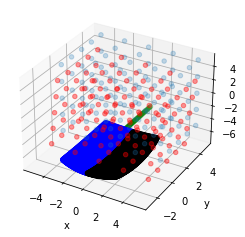

In [39]:
# %matplotlib widget

pillar = torch.stack([torch.ones((32,))*0.2913, 
                      torch.linspace(0, 5, 32), 
                     torch.ones((32,))*-4.0450], -1)
pillar = util.repeat_interleave(pillar.unsqueeze(0), 2)

frustrum_points_np = detach_all(frustrum_points)
single_plane_np = detach_all(single_plane)
frustrum_cam_np = detach_all(frustrum_cam)
single_plane_cam_np = detach_all(single_plane_cam).reshape(-1, 128, 128, 3)

pillar_np = detach_all(pillar)
x = 1
z = 1

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(world_grids_np[0, :, 0], 
           world_grids_np[0, :, 1], 
           world_grids_np[0, :, 2], alpha=0.25)

ax.scatter(camera_grids_np[0, :, 0], 
           camera_grids_np[0, :, 1], 
           camera_grids_np[0, :, 2], alpha=0.4, c="r")
# camera_grids_np = camera_grids_np.reshape(-1, grid_size, grid_size, grid_size, 3)

# ax.scatter(camera_grids_np[0, x, :, z, 0], camera_grids_np[0, x, :, z, 1], camera_grids_np[0, x, :, z, 2], c="k")
# camera_grids_np = camera_grids_np.reshape(2, -1, 3)
ax.scatter(pillar_np[0, :, 0], 
           pillar_np[0, :, 1], 
           pillar_np[0, :, 2], c="g")

# ax.scatter(frustrum_points_np[0, :, 0], 
#            frustrum_points_np[0, :, 1], 
#            frustrum_points_np[0, :, 2])
ax.scatter(single_plane_cam_np[0, :,  :-64, 0], 
           single_plane_cam_np[0, :, :-64, 1], 
           single_plane_cam_np[0, :,  :-64, 2], c="b")

ax.scatter(single_plane_cam_np[0, :, 64:, 0], 
           single_plane_cam_np[0, :, 64:, 1], 
           single_plane_cam_np[0, :, 64:, 2], c="k")

# ax.scatter(single_plane_np[0, :, 0], 
#            single_plane_np[0, :, 1], 
#            single_plane_np[0, :, 2])

plt.xlabel("x")
plt.ylabel("y")

In [40]:
single_plane_cam_np.shape

(1, 128, 128, 3)

In [74]:
# Debugging the encode function in GridEncoder
grid_encoder = encoder.GridEncoder()
grid_encoder.cuda()
print(images.shape, poses.shape, focal.shape, c.shape)
# latent = grid_encoder(images, poses, focal, c)
latent, orig_latent = grid_encoder(images[:, :2], poses[:2], focal[:], c[:])
# latent = grid_encoder(images[:, 1:], poses[1:], focal[:, :1], c[:, :1])

Using torchvision resnet34 encoder
torch.Size([1, 5, 3, 128, 128]) torch.Size([5, 4, 4]) torch.Size([1, 2]) torch.Size([1, 2])
World grid (single): torch.Size([1, 2097152, 3])
World grid (multiple): torch.Size([2, 2097152, 3])
World grid (multiple) after world2camera: torch.Size([2, 2097152, 3])
tensor([-5.3825, -6.0000, -7.0291], device='cuda:0')
tensor([ 7.0038, -1.0000,  5.3018], device='cuda:0')
tensor(-7.0291, device='cuda:0') tensor(5.3018, device='cuda:0')
SPATIAL ENCODER index: uv torch.Size([2, 2097152, 2]) tensor(-5008297.5000, device='cuda:0') tensor(15438092., device='cuda:0')
torch.Size([2, 2097152, 2])
Samples shape from spatial encoder: torch.Size([2, 3, 2097152, 1])
Latent shape from spatial encoder:  torch.Size([2, 3, 2097152])
Latent shape BEFORE averaging over y:  torch.Size([2, 3, 128, 128, 128])
Latent shape AFTER averaging over y:  torch.Size([2, 3, 128, 128])
Latent shape BEFORE averaging over num_views:  torch.Size([1, 2, 3, 128, 128])
Latent shape AFTER averagi

In [75]:
poses.shape

torch.Size([5, 4, 4])

In [76]:
# genc_gridsz = grid_encoder.grid_size
# genc_world_grids = grid_encoder.world_grids.reshape(SB, genc_gridsz, genc_gridsz, genc_gridsz, 3)
# genc_cam_grids = grid_encoder.camera_grids.reshape(SB, genc_gridsz, genc_gridsz, genc_gridsz, 3)
# genc_world_grids_np = detach_all(genc_world_grids)
# genc_cam_grids_np = detach_all(genc_cam_grids)

# cam2world = poses[:1]
# rot = cam2world[:, :3, :3].transpose(1, 2)  # (B, 3, 3)
# trans = -torch.bmm(rot, cam2world[:, :3, 3:])
# w_xyz = genc_world_grids[:1, 0, ::16, 0, :]
# cam_rot = torch.matmul(rot[:, None, :3, :3], w_xyz.unsqueeze(-1))[..., 0]
# cam_xyz = cam_rot + trans[:, None, :, 0]
# cam_xyz = detach_all(cam_xyz)

# plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(genc_world_grids_np[0, ::16, ::16, ::16, 0], 
#            genc_world_grids_np[0, ::16, ::16, ::16, 1], 
#            genc_world_grids_np[0, ::16, ::16, ::16, 2], alpha=0.25)

# ax.scatter(genc_world_grids_np[0, 0, ::16, 0, 0], 
#            genc_world_grids_np[0, 0, ::16, 0, 1], 
#            genc_world_grids_np[0, 0, ::16, 0, 2], c="g")

# ax.scatter(genc_cam_grids_np[0, ::16, ::16, ::16, 0], 
#            genc_cam_grids_np[0, ::16, ::16, ::16, 1], 
#            genc_cam_grids_np[0, ::16, ::16, ::16, 2], alpha=0.25)

# ax.scatter(genc_cam_grids_np[0, 0, ::16, 0, 0], 
#            genc_cam_grids_np[0, 0, ::16, 0, 1], 
#            genc_cam_grids_np[0, 0, ::16, 0, 2], c="k")

# ax.scatter(cam_xyz[0, ..., 0], 
#            cam_xyz[0, ..., 1], 
#            cam_xyz[0, ..., 2], c="b")
# plt.xlabel("x")
# plt.ylabel("y")

In [77]:
focal

tensor([[ 131.2500, -131.2500]], device='cuda:0')

In [78]:
%matplotlib inline

In [79]:
images.shape

torch.Size([1, 5, 3, 128, 128])

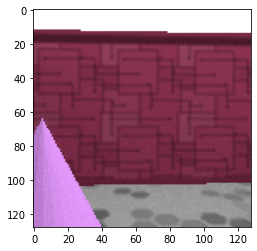

In [80]:
plt.imshow(detach_all(images[0, 1]).transpose(1,2,0))

In [84]:
latent.shape

torch.Size([1, 3, 128, 128])

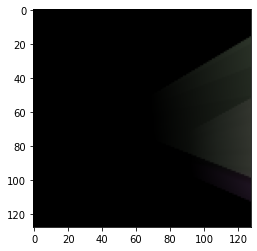

In [82]:
# # This is how the floorplan in the grid encoder looks like
plt.imshow(detach_all(latent[0]).transpose(1,2,0))
# plt.imshow(detach_all(latent[0].mean(0).unsqueeze(0)).transpose(1,2,0))

In [67]:
camview_focal = focal.clone()
# camview_focal[..., -1] *= -1 
print(camview_focal)
uv_proj = util.projection(single_plane_cam, camview_focal, c)
# uv_proj.
# uv_proj[..., -1]  
print(uv_proj.shape)

tensor([[ 131.2500, -131.2500]], device='cuda:0')
torch.Size([1, 16384, 2])


In [68]:
# checking what is stored in the latent of the spatial encoder in the grid encoder
latent, uv_ch = grid_encoder.spatial_encoder.index(uv_proj, None, image_shape.cuda())


SPATIAL ENCODER index: uv torch.Size([1, 16384, 2]) tensor(-7.6294e-06, device='cuda:0') tensor(127.0000, device='cuda:0')
torch.Size([2, 16384, 2])
Samples shape from spatial encoder: torch.Size([2, 3, 16384, 1])


(2, 3, 16384)
(2, 3, 128, 128)


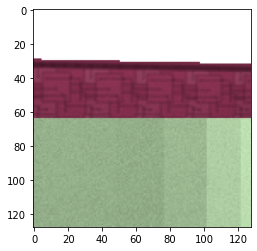

In [69]:
latent_np = util.detach_all(latent)
print(latent_np.shape)
latent_np = latent_np.reshape(-1, 3, 128, 128)
# latent_np = latent_np.reshape(-1, 512, 128, 128)[0, 0, ...].reshape(-1, 1, 128, 128)
print(latent_np.shape)
plt.imshow(latent_np[0].transpose(1, 2, 0))
# latent_np = latent_np.reshape(1, 512, -1)

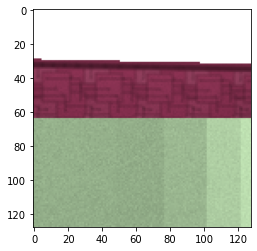

In [70]:
plt.imshow(util.detach_all(images[0, 0]).transpose(1, 2, 0))

In [71]:
sp_enc_raw_latent = grid_encoder.spatial_encoder.latent

In [72]:
sp_enc_raw_latent.shape

torch.Size([2, 3, 128, 128])

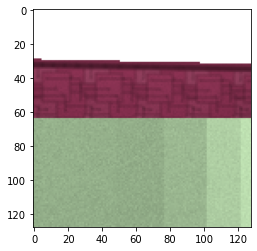

In [73]:
plt.imshow(util.detach_all(sp_enc_raw_latent[0]).transpose(1, 2, 0))

In [34]:
# latent_np = util.detach_all(latent)
# print(latent_np.shape)
# latent_np = latent_np.reshape(-1, 3, 128, 128)
# plt.imshow(latent_np[1].transpose(1, 2, 0))
# latent_np = latent_np.reshape(2, 3, -1)

In [35]:
# plt.imshow(util.detach_all(images[0, 1]).transpose(1, 2, 0))

# Checking index function of the grid encoder

In [36]:
# Check 1: checking for the entire x, z plane. Expected output is the floorplan grid that we saw earlier.
world_grid = util.get_world_grid([[-side_length, side_length],
                                  [0, side_length],
                                  [-side_length, side_length]], 
                                 [128]).cuda()

In [37]:
# uv = np.mgrid[0:128, 0:128].astype(np.int32).transpose(1, 2, 0)
# uv = torch.from_numpy(np.flip(uv, axis=-1).copy()).long()

# uv = uv.view(1, -1, 2).cuda() #* 4

# cam_rays = geometry.get_ray_directions(uv, poses[:1], focal[:1], c[:1])
# sampling_planes = torch.linspace(0.1, 7., 32).cuda()
# cam_pos = poses[:1, :3, 3]
# frustrum_points = cam_pos[None] + sampling_planes[None, :, None, None] * cam_rays[:, None]
# print(frustrum_points.shape)
# single_plane = frustrum_points[:, 10, ...]
# print(single_plane.shape)
# frustrum_points = frustrum_points.reshape(1, -1, 3)


In [38]:
uv = torch.stack([world_grid[..., 0], world_grid[..., -1]], dim=-1).cuda()

In [39]:
uv.shape

torch.Size([1, 2097152, 2])

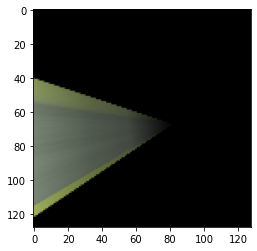

In [40]:
plt.imshow(detach_all(grid_encoder.latent[0]).transpose(1,2,0))

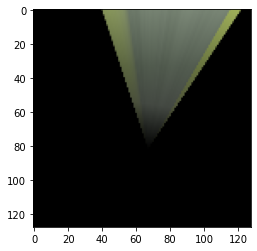

In [41]:
# index with uv generated above
world_latent = grid_encoder.index(
                    uv, None, None
                )  # (1, 3, NC = 128*128*128)

# reshape to L, 128, 128, 128
world_latent = world_latent.reshape(3, 128, 128, 128)
plt.imshow(detach_all(world_latent.mean(2)).transpose(1,2,0))

# world_latent = world_latent.reshape(512, 128, 128, 128)
# plt.imshow(detach_all(world_latent.mean(2).mean(0).unsqueeze(0)).transpose(1,2,0))

In [42]:
# check with a single plane orthogonal to xz-plane in the frustrum of the first view

In [93]:
cam_rays = util.gen_rays(poses[:1], 128, 128, focal, 0.01, 7, c=c)
cam_rays = cam_rays.reshape(-1, 8)

poses.shape, focal.shape, c.shape
near, far = cam_rays[:, -2:-1], cam_rays[:, -1:]  # (B, 1)
# Sampling along the steps
samples_per_ray = 128
step = 1.0 / samples_per_ray
B = cam_rays.shape[0]
z_steps = torch.linspace(0, 1 - step, samples_per_ray).cuda()  # (Kc)
z_steps = z_steps.unsqueeze(0).repeat(B, 1)  # (B, Kc)
z_samples = near * (1 - z_steps) + far * z_steps  # (B, Kf)
print(z_samples.shape)
points = cam_rays[:, None, :3] + z_samples.unsqueeze(2) * cam_rays[:, None, 3:6]
print(points.shape)
points = points.reshape(1, -1, 3)
# points = points.cpu()
print(points[..., 0].min(), points[..., 0].max())
print(points[..., -1].min(), points[..., -1].max())

indices = (points / torch.Tensor([5, 5, 5]).cuda() + torch.Tensor([1, 0, 1]).cuda())/torch.Tensor([2, 1, 2]).cuda() * 128
indices = detach_all(indices.type(torch.long))

torch.Size([16384, 128])
torch.Size([16384, 128, 3])
tensor(-1.6138, device='cuda:0') tensor(5.3246, device='cuda:0')
tensor(-2.2653, device='cuda:0') tensor(3.5796, device='cuda:0')


In [94]:
canvas = torch.zeros((3, 128, 128, 128))
for ind in indices[0]:
    x, y, z = ind
    if x >= 0 and y >= 0 and z >= 0 and x < 128 and y < 128 and z < 128:
        canvas[..., x, y, z] = 1 #world_latent[..., x, y, z]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data/vision/billf/eht/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-5233a365e822>", line 4, in <module>
    if x >= 0 and y >= 0 and z >= 0 and x < 128 and y < 128 and z < 128:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/vision/billf/eht/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/vision/billf/eht/miniconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.imshow(canvas.mean(2).permute(1,2,0))

In [ ]:
uv = torch.stack([points[..., 0], points[..., -1]], dim=-1).cuda()

In [ ]:
latent = grid_encoder.index(uv, None, None)

In [ ]:
latent.shape

In [ ]:
canvas = torch.zeros((3, 128, 128, 128))

In [ ]:
canvas = torch.zeros((3, 128, 128, 128))
for i in range(latent.shape[-1]):
    x, y, z = indices[0, i, :]
#     break
    if x >= 0 and y >= 0 and z >= 0 and x < 128 and y < 128 and z < 128:
        canvas[..., x, y, z] = latent[0, ..., i].sum()
        #         canvas[..., x, y, z] = latent[0, ..., i]        


In [ ]:
plt.imshow(normalize(detach_all(canvas.mean(2).permute(1,2,0))))

In [773]:
# Vincent's method for generating points along rays
uv = np.mgrid[0:128, 0:128].astype(np.int32).transpose(1, 2, 0)
uv = torch.from_numpy(np.flip(uv, axis=-1).copy()).long()
uv = uv.view(1, -1, 2).cuda()

cam_rays = geometry.get_ray_directions(uv, poses[:1], focal[:1], c[:1])
sampling_planes = torch.linspace(0.1, 7., 32).cuda()
cam_pos = poses[:1, :3, 3]
frustrum_points = cam_pos[None] + sampling_planes[None, :, None, None] * cam_rays[:, None]
print(frustrum_points.shape)
single_plane = frustrum_points[:, 10, ...]
print(single_plane.shape)
frustrum_points = frustrum_points.reshape(1, -1, 3)


torch.Size([1, 32, 16384, 3])
torch.Size([1, 16384, 3])


In [781]:
cam_pos

tensor([[ 0.9635,  1.0000, -0.8655]], device='cuda:0')

In [1]:
uv = np.mgrid[0:128, 0:128].astype(np.int32).transpose(1, 2, 0)
uv = torch.from_numpy(np.flip(uv, axis=-1).copy()).long()

uv = uv.view(1, -1, 2).cuda() #* 4
print(uv.min(), uv.max())
print(uv.shape)

NameError: name 'np' is not defined

In [ ]:
cam_rays = geometry.get_ray_directions(uv, poses[1:], focal[:1], c[:1])
sampling_planes = torch.linspace(0.01, 7., 32).cuda()
cam_pos = poses[:1, :3, 3]


plane_index = 15

frustrum_points = cam_pos[None] - sampling_planes[None, :, None, None] * cam_rays[:, None]
single_plane = frustrum_points[:, plane_index, ...]
frustrum_points = frustrum_points.reshape(1, -1, 3)

uv = torch.stack([single_plane[..., 0], single_plane[..., -1]], dim=-1).cuda()

world_latent = world_latent.detach().cpu()

indices = (single_plane / torch.Tensor([5, 5, 5]).cuda() + torch.Tensor([1, 0, 1]).cuda())/torch.Tensor([2, 1, 2]).cuda() * 128
indices = detach_all(indices.type(torch.long))

canvas = torch.zeros((3, 128, 128, 128))
for ind in indices[0]:
    x, y, z = ind
    if x >= 0 and y >= 0 and z >= 0 and x < 128 and y < 128 and z < 128:
        canvas[..., x, y, z] = 1 #world_latent[..., x, y, z]
#     break

plt.imshow(canvas.mean(2).permute(1,2,0))



latent = grid_encoder.index(
                    uv, None, None
                )  # (1, 3, NC = 128*128)

# reshape to 3, 128, 128, 128
latent = latent.reshape(3, 128, 128)

plt.imshow(detach_all(latent).transpose(1,2,0))

uv = torch.Tensor(detach_all(uv))
uv_in_imagecoords = uv/5 * 128
uv_in_imagecoords = uv_in_imagecoords.type(torch.long)
# uv_in_imagecoords[] = 

canvas = torch.zeros((128, 128, 3))

In [775]:
# uv = torch.stack([points[..., 0], points[..., -1]], dim=-1).flip(-1).cuda()
uv = torch.stack([single_plane[..., 0], single_plane[..., -1]], dim=-1).cuda()

In [776]:
print(uv[..., 0].min(), uv[..., 0].max())
print(uv[..., 1].min(), uv[..., 1].max())

tensor(1.8212, device='cuda:0') tensor(3.2140, device='cuda:0')
tensor(-0.3280, device='cuda:0') tensor(1.2635, device='cuda:0')


In [777]:
latent = grid_encoder.index(
                    uv, None, None
                ) 


 UV min max in index:  tensor(0.3642, device='cuda:0') tensor(0.6428, device='cuda:0') 
 tensor(-0.0656, device='cuda:0') tensor(0.2527, device='cuda:0') 

torch.Size([1, 16384, 1, 2])


In [778]:
uv.shape

torch.Size([1, 16384, 2])

In [779]:
latent

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [780]:
latent = latent.reshape(1, 3, 128, 128)

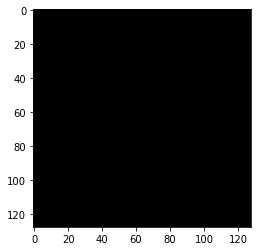

In [745]:
plt.imshow(util.detach_all(latent[0]).transpose(1,2,0))

In [638]:
uv = torch.stack([points[..., 0], points[..., -1]], dim=-1).flip(-1).cuda()

In [629]:
l = latent[0][..., 0]
l.shape

torch.Size([3])

In [682]:
plt.imshow(util.detach_all(l).transpose(1,2,0))

ValueError: axes don't match array

In [ ]:
latent

In [141]:
latent.shape

torch.Size([1, 512, 16384, 10])

In [157]:
uv

tensor([[[ 0.1694, -0.4673],
         [ 0.2106, -0.5868],
         [ 0.2518, -0.7063],
         ...,
         [-0.3243, -1.2122],
         [-0.3926, -1.3188],
         [-0.4608, -1.4255]]], device='cuda:0')

In [ ]:
# Step 1: Build per-camera point clouds in camera coordinates

# Loop through (image, depth, cam2world tuples)
# For each image, unproject each pixel into cam coordinates using (u, v, depth), c, and f.
# For each image, transform that point cloud into world coordinates using cam2world.
# Concate all these points and plot them in 3D.